In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import utils, archimedean, extreme, importlib
import importlib

import time
import pickle

%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "font.size":22})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size":22})

In [2]:
# load data
print("#1 load data")

path = './data/synthetic/CNSD_C_1_14.p'
U0 = utils.load_data_0(path).float();
nsamples = 240 # monthly maxima
U0 = U0*nsamples/(nsamples+1)

ndims = 3

labels = ["Belle-Ile", "Groix", "Lorient"]

#1 load data


In [3]:
phi = archimedean.PhiDMStochastic(ndims)
ckpt = torch.load('./checkpoints/ckpt_EE_2R_i%d.ckpt'%(5000))
phi.model.load_state_dict(ckpt['model_state_dict'])
phi.resample_R(10000)

stdf_GNN = extreme.stdfStochastic(ndims=ndims)
opt_stdf = torch.optim.Adam(stdf_GNN.parameters(), lr=1e-3)
ckpt = torch.load('./checkpoints/ckpt_EE_1exp_i%d.ckpt'%(5000))
stdf_GNN.load_state_dict(ckpt['model_state_dict'])
opt_stdf.load_state_dict(ckpt['optimizer_state_dict'])
stdf_GNN.resample_M(10000)

stdfCFG = extreme.stdfCFG(U0, phi=phi)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [4]:
stdf = extreme.stdfNSD(alpha = torch.tensor([1.,2.,3.]), rho = torch.tensor([-0.69]))

In [5]:
U_test = utils.rand_simplex(10000,ndims)

stdfmax = stdfCFG(U_test)
stdfGT = stdf(U_test)
IRAEloss = torch.mean(torch.abs(stdfmax-stdfGT)/stdfGT).item()
print(IRAEloss)

0.03923587501049042


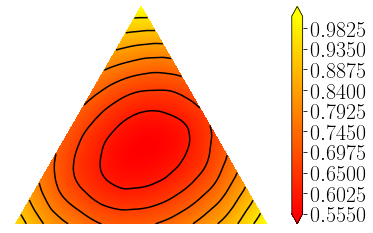

In [6]:
utils.plot_stdf3(stdfCFG)

In [9]:
MSEloss = torch.nn.MSELoss()
onesd = torch.ones(stdf_GNN.ndims)/stdf_GNN.ndims

n_iter = 1100
n_r = 200
n_z = 200
n_batch = 200
time_taken = 0

for iter_stdf in range(n_iter):
        
    time_start = time.time()
    opt_stdf.zero_grad()
    stdf_GNN.resample_M(n_z)
    phi.resample_R(n_r)
    y = U0[np.random.permutation(240)[:n_batch],:].detach()
    w = utils.rand_simplex(n_batch,ndims)
    
    x = torch.min(phi.inverse(y[:,:,None].expand(-1,-1,1))/w.T[None,:,:].expand(1,-1,-1),dim=1)[0]
    A = stdf_GNN(w)[None,:].expand(n_batch,-1)
    ll = torch.log(-phi.ndiff(x*A))+torch.log(A)
    lloss = -torch.mean(ll)
    scaleloss = MSEloss(stdf_GNN.M.mean(dim=0),onesd)
    regloss = lloss + scaleloss
    regloss.backward()
    opt_stdf.step()
    time_end = time.time()
    time_taken += (time_end-time_start)
    
    if iter_stdf%100 == 0:
        
        print(iter_stdf, time_taken, lloss.item(), scaleloss.item())
        
        if torch.isnan(stdf_GNN.sample(1)).sum()>1: 
            ckpt = torch.load(prev_ckpt)
            stdf_GNN.load_state_dict(ckpt['model_state_dict'])
            opt_stdf.load_state_dict(ckpt['optimizer_state_dict'])
            nan_count+= 1
            
            print("nan_count:%d"%nan_count)

            if nan_count == 3:
                break
                
        torch.save({
                'iter_stdf': iter_stdf,
                'model_state_dict': stdf_GNN.state_dict(),
                'optimizer_state_dict': opt_stdf.state_dict(),
            }, './checkpoints/ckpt_EE_3S_i%d.ckpt'%(iter_stdf))
        
        prev_ckpt = './checkpoints/ckpt_EE_3S_i%d.ckpt'%(iter_stdf)

0 0.30795907974243164 inf 3.4733168376988033e-06
100 31.070531606674194 -0.6371236443519592 2.1397901946329512e-05
200 61.23918843269348 -0.5227714776992798 8.592753147240728e-06
300 86.65891361236572 -0.5304314494132996 5.415456527657625e-08
400 115.31607699394226 -0.5495411157608032 1.7325442968285643e-05
500 142.78395247459412 -0.5065946578979492 6.9304405769798905e-06
600 168.29693865776062 -0.5810575485229492 3.309945668661385e-06
700 192.9770109653473 -0.47470590472221375 2.373387360421475e-05
800 220.01670718193054 -0.4163321256637573 7.7295368328123e-07
900 247.30455470085144 -0.43376317620277405 1.0717754776123911e-05
1000 273.89179849624634 -0.7162845730781555 1.778868136170786e-05


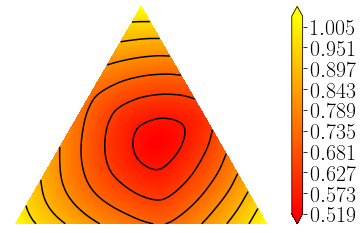

0.0405280627310276


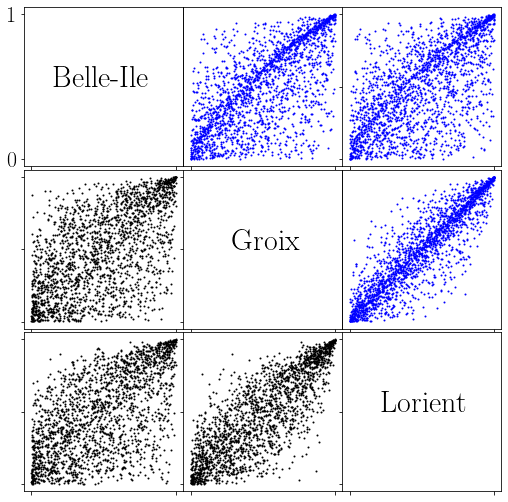

<Figure size 432x288 with 0 Axes>

In [10]:
Uev = stdf_GNN.sample(200000).view(100,2000,ndims).max(dim=0)[0].detach().numpy()
for i in range(ndims):
    Uev[:, i] = scipy.stats.rankdata(Uev[:, i], 'ordinal')/2000
utils.plot_stdf3(extreme.stdfCFG(torch.tensor(Uev)))

U_test = utils.rand_simplex(10000,ndims)

stdfmax = extreme.stdfCFG(torch.tensor(Uev))(U_test)
stdfGT = stdf(U_test)
IRAEloss = torch.mean(torch.abs(stdfmax-stdfGT)/stdfGT).item()
print(IRAEloss)

Uev0, W = stdf.sample(2000)
utils.plot_U1_U2(torch.tensor(Uev), Uev0, labels=labels)

In [12]:
a = 1 # a (2.1971,1.6551) if Gumbel or Joe
stdfGT = stdf(U_test**a)**(1/a) 
stdfmax = extreme.stdfCFG(torch.tensor(Uev))(U_test)
IRAEloss = torch.mean(torch.abs(stdfmax-stdfGT)/stdfGT).item()
print(IRAEloss)

0.0405280627310276
